In [93]:
#导入相关的库
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib as mpl
import gc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time
import datetime
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from scipy import sparse
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
np.set_printoptions(suppress=True)  # 取消科学技术法
import pickle

In [5]:
filepath = 'F:/BaiduNetdiskDownload/adevertisment/advertisement.csv'
data = pd.read_csv(filepath)

In [6]:
data.head()

,Unnamed: 0,instance_id,time,city,province,user_tags,carrier,devtype,make,model,nnt,os,osv,os_name,adid,advert_id,orderid,advert_industry_inner,campaign_id,creative_id,creative_tp_dnf,app_cate_id,f_channel,app_id,inner_slot_id,creative_type,creative_width,creative_height,creative_is_jump,creative_is_download,creative_has_deeplink,advert_name,day,hour,area,ad_prefix,advert_industry_inner1,advert_industry_inner2,click
0,0,4871560165930991338,2190038403,106105106,106105,"3003779,3003779,3003843,3003851,3003863,300386...",3,2,Vivo,vivo X20,4,2,7.1.1,android,1574532,230000063,3011352,102400_102401,1000023,2316955,8390430283595430291,108.0,-1,2090618.0,xf_D0CF499C7D134CDF81DF9D544CC557FB,8,960,640,True,False,False,B4734117F35EE97F,0,0,614400,157,102400,102401,0
1,1,1156288606795451147,2190038408,101105106,101105,"3003779,3003843,3003845,3003851,3003863,300387...",2,2,Vivo,vivo+Y79A,4,2,7.1.2,android,1549532,230000063,3009080,102400_102401,1000023,2334795,8390430283595430291,100.0,-1,2089397.0,xf_7F9FF3BEA11FE5B3AE6332EFBBD59496,8,960,640,True,False,False,B4734117F35EE97F,0,0,614400,154,102400,102401,0
2,2,2886794733240524743,2190038409,104102106,104102,-1,1,2,Apple,iPhone 5s (Global),3,1,8.1.1,ios,1576184,230001696,3011756,101000_101002,1003456,2341772,8390272894417697957,103.0,-1,1030051.0,xf_A6B1A635D568FB987B7CF391E0F54325,5,320,480,True,False,False,310405E93895BD58,0,0,153600,157,101000,101002,0
3,3,2117825034610349718,2190038409,104104106,104104,"2100041,2100042,2100030,2100198,2100265,210002...",1,2,Oppo,OPPO%252BR9tm,4,2,5.1,android,1559244,230000833,3006065,4_100206,1002835,2340218,8390422898336367555,107.0,-1,1100001.0,xf_1587571EC0815824E91C5686EDCAC4A7,2,100,640,True,False,False,862FF2E9B0AD4C14,0,0,64000,155,4,100206,0
4,4,5597056059236856846,2190038409,105102117,105102,"3003273,3003339,3003379,3003537,3003559,300371...",1,2,Vivo,vivo Y67,1,2,6.0,android,1576214,230001696,3011762,101000_101002,1003456,2341782,8390404739335806554,100.0,-1,2081009.0,xf_369A1421E21367AEFDEDE71A1C54B766,5,300,300,True,False,False,310405E93895BD58,0,0,90000,157,101000,101002,0


In [7]:
del data['Unnamed: 0']

## 特征工程-数据清洗、特征构建

In [8]:
def process(data):
    # 缺失值填充
    data['make'] = data['make'].fillna(str(-1))
    data['model'] = data['model'].fillna(str(-1))
    data['osv'] = data['osv'].fillna(str(-1))
    data['app_cate_id'] = data['app_cate_id'].fillna(-1)
    data['app_id'] = data['app_id'].fillna(-1)
    data['user_tags'] = data['user_tags'].fillna(str(-1))
    data['f_channel'] = data['f_channel'].fillna(str(-1))
    
    #数据预处理
    data['model'] = data['model'].apply(lambda x: str(x).lower())
    data['make'] = data['make'].apply(lambda x: str(x).lower())
    
    a1= data.model.apply(lambda x: '+' if '+' in str(x) else 
                         '-' if '-' in str(x) else \
                         '_' if '_' in str(x) else \
                         ',' if ',' in str(x) else \
                         'chinese' if u'[\u4E00-\u9FA5]' in str(x) else \
                         '%2b' if '%2b' in str(x) else \
                         '%20' if '%20' in str(x) else \
                         '%2522' if '%2522' in str(x) else \
                         '%25' if '%25' in str(x) else \
                         'other')
    data['sim_ip'] = a1   #数据规范
    #make字段异常值清洗
    new = data[['make', 'model', 'instance_id']]
    new['make_model'] = new['make']+':::'+new['model']
    for i in ['apple', 'oppo', 'vivo', 'huawei', 'lenovo', 'zte', 'xiaomi', 'meizu', 'gionee', 'samsung', 'honor', '360', 'lemobile',\
              'zte', 'letv', 'cmdc', 'hisense', 'oneplus', 'nubia', 'yulong', 'smartisan', 'coolpad', 'doov', 'bbk', 'xiaolajiao',  \
              'le', 'koobee', 'blephone', 'meitu', 'sprd', 'alps', 'konka', 'leeco', 'sugar', 'lephone', 'zuk', 'pa', 'htc',  \
              'yufly', 'tcl', 'ipad', 'changhong', 'sony', 'android', 'sm', 'yufly', 'mha', 'motorola', 'bln', 'vtr',    \
              'asus', '4g', 'ivvi', 'lge', 'qingcheng', 'qiku', 'kopo', 'saga']:
        length = len(i)
        new['make_model'] = new['make_model'].apply(lambda x: i if ((len(x.split(':::')) > 1) and  ((x.split(':::')[0][:length] == i) | (x.split(':::')[1][:length] == i))) else x)
        new['make_model'] = new['make_model'].apply(lambda x: i if ((len(x.split(':::')) > 1) and  ((i in x.split(':::')[0]) | (i in x.split(':::')[1]))) else x)
    new['make_model'] = new['make_model'].apply(lambda x: 'apple' if x[:6] == 'iphone' else x)
    new['make_model'] = new['make_model'].apply(lambda x: 'xiaomi' if 'mi' in x else x)
    new['make_model'] = new['make_model'].apply(lambda x: 'apple' if 'phone' in x else x)
    new['make_model'] = new['make_model'].apply(lambda x: 'apple' if 'ios' in x else x)
    new['make_model'] = new['make_model'].apply(lambda x: 'meizu' if 'mx' in x else x)
    new.loc[new.make_model.isin((new.make_model.value_counts()[new.make_model.value_counts() <= 200]).index), 'make_model'] = 'other' #去除低频词
    data['clear_make'] = new['make_model'].copy()
    print('make变量处理完毕')
    
    #对于操作系统的处理
    import re
    new = data[['osv', 'instance_id']]
    new.loc[new.osv.isnull(), 'osv'] = '6.0.1'
    new['osv'] = new['osv'].apply(lambda x: str(x).lower())
    new['digit_osv'] = new['osv'].apply(lambda x: re.findall(r"\d+\.\d+\.\d*",x)[0] if len(re.findall(r"\d+\.\d+\.\d*",x)) > 0 else  re.findall(r"\d+\.?\d*", x)[0] if len(re.findall(r"\d+\.?\d*", x)) > 0 else 'other')
    new['clear_osv'] = data['os_name'] + new['digit_osv']
    data['clear_osv'] = new['clear_osv'].copy()
    print('操作系统osv处理完毕')
    
    replace = ['creative_is_jump', 'creative_is_download', 'creative_has_deeplink']
    for feat in replace:
        data[feat] = data[feat].replace([False, True], [0, 1])
    # labelencoder 转化
    encoder = ['city', 'province', 'make', 'model', 'osv', 'os_name', 'adid', 'advert_id', 'orderid',
               'advert_industry_inner', 'campaign_id', 'creative_id', 'app_cate_id', 'sim_ip',
               'app_id', 'inner_slot_id', 'advert_name', 'f_channel', 'creative_tp_dnf', 'clear_make', 'clear_osv']
    lbl = LabelEncoder()
    for feat in encoder:
        lbl.fit(data[feat])
        data[feat] = lbl.transform(data[feat])
    return data

In [9]:
#初步处理
data = process(data)

make变量处理完毕
操作系统osv处理完毕


In [10]:
data.head()

,instance_id,time,city,province,user_tags,carrier,devtype,make,model,nnt,os,osv,os_name,adid,advert_id,orderid,advert_industry_inner,campaign_id,creative_id,creative_tp_dnf,app_cate_id,f_channel,app_id,inner_slot_id,creative_type,creative_width,creative_height,creative_is_jump,creative_is_download,creative_has_deeplink,advert_name,day,hour,area,ad_prefix,advert_industry_inner1,advert_industry_inner2,click,sim_ip,clear_make,clear_osv
0,4871560165930991338,2190038403,320,31,"3003779,3003779,3003843,3003851,3003863,300386...",3,2,354,1859,4,2,70,0,622,1,350,16,1,72,30,9,0,432,1063,8,960,640,1,0,0,24,0,0,614400,157,102400,102401,0,7,72,39
1,1156288606795451147,2190038408,30,5,"3003779,3003843,3003845,3003851,3003863,300387...",2,2,354,2274,4,2,71,0,268,1,219,16,1,154,30,1,0,254,841,8,960,640,1,0,0,24,0,0,614400,154,102400,102401,0,3,72,40
2,2886794733240524743,2190038409,174,17,-1,1,2,18,647,3,1,77,1,818,31,459,5,31,435,14,4,0,5,936,5,320,480,1,0,0,5,0,0,153600,157,101000,101002,0,7,25,88
3,2117825034610349718,2190038409,202,19,"2100041,2100042,2100030,2100198,2100265,210002...",1,2,258,1381,4,2,59,0,535,12,164,20,15,265,28,8,0,12,580,2,100,640,1,0,0,19,0,0,64000,155,4,100206,0,1,59,29
4,5597056059236856846,2190038409,251,23,"3003273,3003339,3003379,3003537,3003559,300371...",1,2,354,1949,1,2,62,0,825,31,462,5,31,440,24,1,0,196,644,5,300,300,1,0,0,5,0,0,90000,157,101000,101002,0,7,72,32


##  组合特征，构造历史点击率

In [11]:
##特征组合
def combine_feature_time_feature(data):
    lbl = LabelEncoder()
    
    #组合特征
    data['meiti_con_inner'] = data['app_id'].astype(str) + data['inner_slot_id'].astype(str)
    data['meiti_con_inner'] = lbl.fit_transform(data['meiti_con_inner'])
    data['meiti_con_inner_con_channel'] = data['app_id'].astype(str) + data['inner_slot_id'].astype(str) + data['f_channel'].astype(str)
    data['meiti_con_inner_con_channel']  = lbl.fit_transform(data['meiti_con_inner_con_channel'] )
    
    data['app_cate_con_adid'] = data['app_cate_id'].astype(str) + data['adid'].astype(str)
    data['app_cate_con_adid'] = lbl.fit_transform(data['app_cate_con_adid'])
    
    data['app_cate_con_meiti'] = data['app_cate_id'].astype(str) + data['app_id'].astype(str)
    data['app_cate_con_meiti'] = lbl.fit_transform(data['app_cate_con_meiti'])
    
    #加入
    data['model_con_osv'] = data['model'].astype(str) + data['osv'].astype(str)
    data['model_con_osv'] = lbl.fit_transform(data['model_con_osv'])
    
    data['model_con_city'] = data['model'].astype(str) + data['city'].astype(str)
    data['model_con_city'] = lbl.fit_transform(data['model_con_city'])
    
    #处理时间
    data['day'] = data['time'].apply(lambda x : int(time.strftime("%d", time.localtime(x))))
    data['hour'] = data['time'].apply(lambda x : int(time.strftime("%H", time.localtime(x)))) 
    
     # 构造历史点击率
    # 时间转换,转换的day包括5月和6月
    data['period'] = data['day']
    data['period'][data['period']<27] = data['period'][data['period']<27] + 31   
    
    for feat_1 in ['advert_id','advert_industry_inner','advert_name','campaign_id', 'creative_height',
                   'creative_tp_dnf', 'creative_width', 'province', 'f_channel']:
        gc.collect()
        res=pd.DataFrame()
        temp=data[[feat_1,'period','click']]
        
        for period in range(27,35):
            if period == 27:
                count=temp.groupby([feat_1]).apply(lambda x: x['click'][(x['period']<=period).values].count()).reset_index(name=feat_1+'_all')
                count1=temp.groupby([feat_1]).apply(lambda x: x['click'][(x['period']<=period).values].sum()).reset_index(name=feat_1+'_1')
            else: 
                count=temp.groupby([feat_1]).apply(lambda x: x['click'][(x['period']<period).values].count()).reset_index(name=feat_1+'_all')
                count1=temp.groupby([feat_1]).apply(lambda x: x['click'][(x['period']<period).values].sum()).reset_index(name=feat_1+'_1')
                
            count[feat_1+'_1']=count1[feat_1+'_1']
            count.fillna(value=0, inplace=True)
    
            count[feat_1+'_rate'] = round(count[feat_1+'_1'] / count[feat_1+'_all'], 5)
        
            count['period']=period
            count.drop([feat_1+'_all', feat_1+'_1'],axis=1,inplace=True)
            count.fillna(value=0, inplace=True)
            res=res.append(count,ignore_index=True)
        print(feat_1,' over')
        data = pd.merge(data,res, how='left', on=[feat_1,'period'])
    return data

In [12]:
data = combine_feature_time_feature(data)

advert_id  over
advert_industry_inner  over
advert_name  over
campaign_id  over
creative_height  over
creative_tp_dnf  over
creative_width  over
province  over
f_channel  over


In [14]:
data.to_csv('F:/BaiduNetdiskDownload/adevertisment/advertisement02.csv')

In [15]:
data_click1 = data[data['click']==1]
data_click0 = data[data['click']==0]
data_click0 = data_click0.sample(n=198787)
data_half = data_click0.append(data_click1)
data_half = data_half.reset_index(drop= True)

In [17]:
data_new = data_half.sample(n=20000)

In [18]:
data_x1 = data_half.drop('click',axis=1)
data_y1 = data_half.click

In [19]:
###随机切割成训练集和测试集
train_x1,test_x1,train_y1,test_y1 = train_test_split(data_x1,data_y1,train_size=0.9)
print('训练数据特征：',train_x1.shape, '训练数据标签：',train_y1.shape)
print('测试数据特征：',test_x1.shape, '测试数据标签：',test_y1.shape)

训练数据特征： (357816, 56) 训练数据标签： (357816,)
测试数据特征： (39758, 56) 测试数据标签： (39758,)


In [20]:
data_half.nunique()

instance_id                    397574
time                           272912
city                              333
province                           35
user_tags                      188841
carrier                             4
devtype                             4
make                              448
model                            2524
nnt                                 6
os                                  3
osv                               118
os_name                             3
adid                             1868
advert_id                          38
orderid                           918
advert_industry_inner              24
campaign_id                        62
creative_id                       789
creative_tp_dnf                    38
app_cate_id                        22
f_channel                          46
app_id                            359
inner_slot_id                     864
creative_type                       5
creative_width                     19
creative_hei

In [21]:
### 分成不同的特征部分
is_feature = ['creative_is_download', 'creative_is_jump', 'creative_has_deeplink']   
rate_feature = [i for i in data.columns if '_rate' in i]
cate_feature = ['f_channel',  'adid', 'inner_slot_id', 'os', 'advert_industry_inner', 'devtype', 'clear_osv', \
                'creative_height', 'creative_type', 'sim_ip', 'advert_name', 'orderid', 'carrier', 'app_id', 'creative_id', \
                'creative_tp_dnf','app_cate_id', 'creative_width', 'clear_make', 'province', 'nnt', 'city', 'campaign_id','hour'] + is_feature
ignore_feature = ['instance_id', 'period']

In [24]:
train_x1 = train_x1[cate_feature]
test_x1 = test_x1[cate_feature]

In [25]:
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=48, max_depth=-1, learning_rate=0.05, n_estimators=350,
                           max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
                           min_child_weight=5, min_child_samples=150, subsample=0.8, subsample_freq=1,
                           colsample_bytree=1, reg_alpha=3, reg_lambda=5, seed=1000, n_jobs=10, silent=True)

In [26]:
lgb_clf.fit(train_x1, train_y1, eval_set=[(train_x1, train_y1)], eval_metric='auc',early_stopping_rounds=100)

[1]	training's auc: 0.748961	training's binary_logloss: 0.6825
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.751868	training's binary_logloss: 0.672882
[3]	training's auc: 0.752063	training's binary_logloss: 0.664127
[4]	training's auc: 0.752724	training's binary_logloss: 0.656134
[5]	training's auc: 0.752717	training's binary_logloss: 0.648906
[6]	training's auc: 0.75295	training's binary_logloss: 0.642247
[7]	training's auc: 0.753561	training's binary_logloss: 0.636172
[8]	training's auc: 0.753751	training's binary_logloss: 0.630607
[9]	training's auc: 0.753992	training's binary_logloss: 0.625471
[10]	training's auc: 0.754174	training's binary_logloss: 0.620748
[11]	training's auc: 0.754469	training's binary_logloss: 0.616415
[12]	training's auc: 0.754609	training's binary_logloss: 0.612426
[13]	training's auc: 0.755112	training's binary_logloss: 0.608763
[14]	training's auc: 0.755388	training's binary_logloss: 0.605363
[15]	training's auc: 0.75

[124]	training's auc: 0.764912	training's binary_logloss: 0.557191
[125]	training's auc: 0.76496	training's binary_logloss: 0.557149
[126]	training's auc: 0.765028	training's binary_logloss: 0.557107
[127]	training's auc: 0.765093	training's binary_logloss: 0.557055
[128]	training's auc: 0.76513	training's binary_logloss: 0.557016
[129]	training's auc: 0.765183	training's binary_logloss: 0.556971
[130]	training's auc: 0.765242	training's binary_logloss: 0.556931
[131]	training's auc: 0.765304	training's binary_logloss: 0.556891
[132]	training's auc: 0.765379	training's binary_logloss: 0.556844
[133]	training's auc: 0.765429	training's binary_logloss: 0.556799
[134]	training's auc: 0.76547	training's binary_logloss: 0.556761
[135]	training's auc: 0.765519	training's binary_logloss: 0.556721
[136]	training's auc: 0.765572	training's binary_logloss: 0.556673
[137]	training's auc: 0.765617	training's binary_logloss: 0.556636
[138]	training's auc: 0.765675	training's binary_logloss: 0.55658

[246]	training's auc: 0.770261	training's binary_logloss: 0.553084
[247]	training's auc: 0.77029	training's binary_logloss: 0.553062
[248]	training's auc: 0.770309	training's binary_logloss: 0.553036
[249]	training's auc: 0.770357	training's binary_logloss: 0.553007
[250]	training's auc: 0.770404	training's binary_logloss: 0.552978
[251]	training's auc: 0.770455	training's binary_logloss: 0.552945
[252]	training's auc: 0.7705	training's binary_logloss: 0.552912
[253]	training's auc: 0.770543	training's binary_logloss: 0.552883
[254]	training's auc: 0.770582	training's binary_logloss: 0.55285
[255]	training's auc: 0.770615	training's binary_logloss: 0.552822
[256]	training's auc: 0.770654	training's binary_logloss: 0.552796
[257]	training's auc: 0.770691	training's binary_logloss: 0.552767
[258]	training's auc: 0.770726	training's binary_logloss: 0.552744
[259]	training's auc: 0.770772	training's binary_logloss: 0.552717
[260]	training's auc: 0.770809	training's binary_logloss: 0.552693

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
        importance_type='split', learning_rate=0.05, max_bin=425,
        max_depth=-1, min_child_samples=150, min_child_weight=5,
        min_split_gain=0, n_estimators=350, n_jobs=10, num_leaves=48,
        objective='binary', random_state=None, reg_alpha=3, reg_lambda=5,
        seed=1000, silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)

In [29]:
pre_test=lgb_clf.predict(test_x1)

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
accuracy_score(test_y1,pre_test)

0.6956587353488606

In [34]:
#样本中的正例有多少被预测正确
recall_score(test_y1,pre_test)

0.8724089353994767

In [36]:
##  输出特征的重要性
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(
    init=None,
    learning_rate=0.1,
    loss='deviance',
    max_depth=3,
    max_features=None,
    max_leaf_nodes=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=100,
    random_state=None,
    subsample=1.0,
    verbose=0,
    warm_start=False)
print ("fit start!")
gbdt.fit(train_x1,train_y1)
print( "fit success!")
scores = gbdt.feature_importances_

fit start!
fit success!


In [45]:
feat_labels = data_half.columns[:-1]
indices = np.argsort(scores)[::-1]
for f in range(train_x1.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], scores [indices[f]]))

 1) city                           0.172218
 2) model                          0.141785
 3) adid                           0.106964
 4) advert_id                      0.075277
 5) devtype                        0.064572
 6) advert_industry_inner          0.055200
 7) creative_id                    0.052379
 8) time                           0.050237
 9) osv                            0.048898
10) campaign_id                    0.047204
11) user_tags                      0.044530
12) app_id                         0.041279
13) os                             0.027555
14) instance_id                    0.023400
15) nnt                            0.015135
16) app_cate_id                    0.009758
17) orderid                        0.007865
18) make                           0.005476
19) f_channel                      0.003925
20) inner_slot_id                  0.003770
21) province                       0.002020
22) carrier                        0.000302
23) os_name                     

In [54]:
#新建dataframe
fea_list = []
score_list = []
for f in range(train_x1.shape[1]):
    fea_list.append(feat_labels[indices[f]])
    score_list.append(scores[indices[f]].round(4))

In [68]:
fea_importance = {'feature':fea_list,'gbdt_importance':score_list}
fea_importance = pd.DataFrame(fea_importance)

In [69]:
fea_importance

,feature,gbdt_importance
0,city,0.1722
1,model,0.1418
2,adid,0.1070
3,advert_id,0.0753
4,devtype,0.0646
5,advert_industry_inner,0.0552
6,creative_id,0.0524
7,time,0.0502
8,osv,0.0489
9,campaign_id,0.0472


###  将离散型特征进行one-hot编码的作用，是为了让距离计算更合理，但如果特征是离散的，并且不用one-hot编码就可以很合理的计算出距离，那么就没必要进行one-hot编码。 有些基于树的算法在处理变量时，并不是基于向量空间度量，数值只是个类别符号，即没有偏序关系，所以不用进行独热编码。  Tree Model不太需要one-hot编码： 对于决策树来说，one-hot的本质是增加树的深度。

##   随机森林选择特征

In [58]:
data_new = data_half.sample(n=20000).reset_index(drop = True)

In [59]:
data_x = data_new.drop('click',axis=1)
data_y = data_new.click

In [60]:
###随机切割成训练集和测试集
train_x,test_x,train_y,test_y = train_test_split(data_x,data_y,train_size=0.9)
print('训练数据特征：',train_x.shape, '训练数据标签：',train_y.shape)
print('测试数据特征：',test_x.shape, '测试数据标签：',test_y.shape)

训练数据特征： (18000, 56) 训练数据标签： (18000,)
测试数据特征： (2000, 56) 测试数据标签： (2000,)


In [61]:
train_x = train_x[cate_feature]
test_x = test_x[cate_feature]

In [62]:
train_x .head()

,f_channel,adid,inner_slot_id,os,advert_industry_inner,devtype,clear_osv,creative_height,creative_type,sim_ip,advert_name,orderid,carrier,app_id,creative_id,creative_tp_dnf,app_cate_id,creative_width,clear_make,province,nnt,city,campaign_id,hour,creative_is_download,creative_is_jump,creative_has_deeplink
1947,0,72,580,2,16,2,44,640,2,1,24,44,3,12,93,28,8,100,72,10,4,74,1,20,0,1,0
14089,0,190,841,2,10,2,31,640,8,3,31,214,1,254,174,30,1,960,72,17,1,171,0,18,0,1,0
1197,53,620,502,2,11,2,24,720,3,7,19,341,0,156,329,6,1,1280,72,19,1,198,39,17,0,1,0
18957,0,274,1110,2,16,2,24,640,8,7,24,269,1,123,154,30,9,960,75,23,1,251,1,15,0,1,0
16917,0,621,615,2,10,2,22,720,8,5,10,342,1,232,172,12,8,1280,42,14,1,126,12,12,0,1,0


In [63]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = data_half.columns[:-1]
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [64]:
feat_labels = data_new.columns[:-1]

In [65]:
feat_labels

Index(['instance_id', 'time', 'city', 'province', 'user_tags', 'carrier',
       'devtype', 'make', 'model', 'nnt', 'os', 'osv', 'os_name', 'adid',
       'advert_id', 'orderid', 'advert_industry_inner', 'campaign_id',
       'creative_id', 'creative_tp_dnf', 'app_cate_id', 'f_channel', 'app_id',
       'inner_slot_id', 'creative_type', 'creative_width', 'creative_height',
       'creative_is_jump', 'creative_is_download', 'creative_has_deeplink',
       'advert_name', 'day', 'hour', 'area', 'ad_prefix',
       'advert_industry_inner1', 'advert_industry_inner2', 'click', 'sim_ip',
       'clear_make', 'clear_osv', 'meiti_con_inner',
       'meiti_con_inner_con_channel', 'app_cate_con_adid',
       'app_cate_con_meiti', 'model_con_osv', 'model_con_city', 'period',
       'advert_id_rate', 'advert_industry_inner_rate', 'advert_name_rate',
       'campaign_id_rate', 'creative_height_rate', 'creative_tp_dnf_rate',
       'creative_width_rate', 'province_rate'],
      dtype='object')

In [66]:
## 特征的重要性评估
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(train_x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) f_channel                      0.164855
 2) inner_slot_id                  0.144130
 3) creative_tp_dnf                0.109735
 4) devtype                        0.096414
 5) creative_id                    0.066557
 6) model                          0.056941
 7) campaign_id                    0.040102
 8) time                           0.038001
 9) app_id                         0.035061
10) osv                            0.034008
11) advert_id                      0.028083
12) city                           0.025094
13) adid                           0.024966
14) app_cate_id                    0.024061
15) os_name                        0.023676
16) os                             0.020515
17) nnt                            0.019339
18) user_tags                      0.013985
19) advert_industry_inner          0.010915
20) orderid                        0.010004
21) make                           0.006899
22) instance_id                    0.004702
23) province                    

In [73]:
##  将两个模型的特征值重要性画成散点图
fea_list1 = []
score_list1 = []
for f in range(train_x.shape[1]):
    fea_list1.append(feat_labels[indices[f]])
    score_list1.append(importances[indices[f]].round(4))

In [75]:
fea_importance1 = {'feature':fea_list1,'rf_importance':score_list1}
fea_importance1 = pd.DataFrame(fea_importance1)

In [78]:
fea_importance_all = pd.merge(fea_importance,fea_importance1,how = 'inner',on = 'feature')

In [79]:
fea_importance_all

,feature,gbdt_importance,rf_importance
0,city,0.1722,0.0251
1,model,0.1418,0.0569
2,adid,0.1070,0.0250
3,advert_id,0.0753,0.0281
4,devtype,0.0646,0.0964
5,advert_industry_inner,0.0552,0.0109
6,creative_id,0.0524,0.0666
7,time,0.0502,0.0380
8,osv,0.0489,0.0340
9,campaign_id,0.0472,0.0401


Text(0.5,1,'特征影响权重对比')

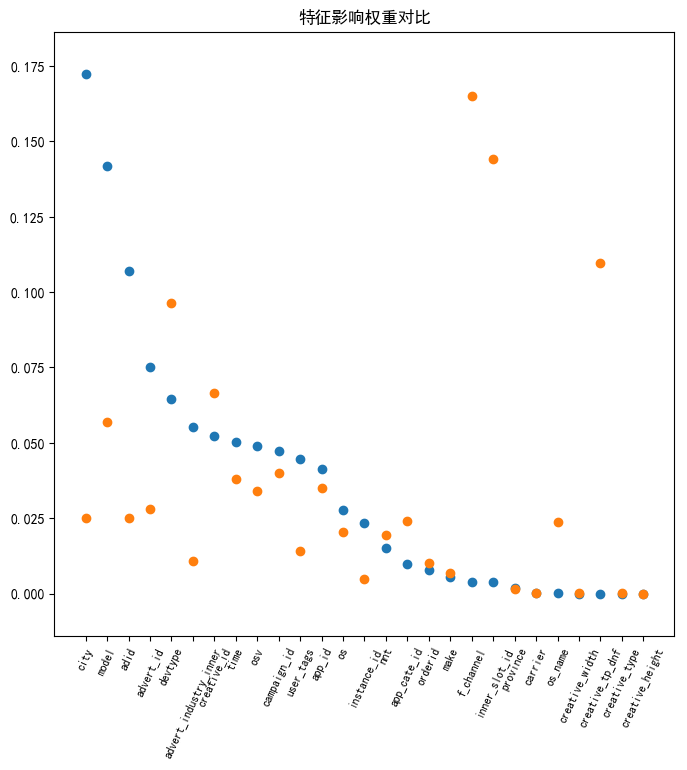

In [94]:
mpl.rcParams['font.family'] = 'SimHei'  
fig=plt.figure(figsize=(8,8),dpi=100)
plt.scatter(fea_importance_all['feature'],fea_importance_all['gbdt_importance'])
plt.scatter(fea_importance_all['feature'],fea_importance_all['rf_importance'])
plt.xticks(fea_importance_all['feature'],rotation = 65,fontsize='small')
plt.title('特征影响权重对比')